In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vietnamese-foods/LICENSE
/kaggle/input/vietnamese-foods/Urls/Banh gio.txt
/kaggle/input/vietnamese-foods/Urls/Bun bo Hue.txt
/kaggle/input/vietnamese-foods/Urls/Banh beo.txt
/kaggle/input/vietnamese-foods/Urls/Banh khot.txt
/kaggle/input/vietnamese-foods/Urls/Banh canh.txt
/kaggle/input/vietnamese-foods/Urls/Banh trang nuong.txt
/kaggle/input/vietnamese-foods/Urls/Banh can.txt
/kaggle/input/vietnamese-foods/Urls/Bun rieu.txt
/kaggle/input/vietnamese-foods/Urls/Cao lau.txt
/kaggle/input/vietnamese-foods/Urls/Banh tet.txt
/kaggle/input/vietnamese-foods/Urls/Hu tieu.txt
/kaggle/input/vietnamese-foods/Urls/Bun thit nuong.txt
/kaggle/input/vietnamese-foods/Urls/Ca kho to.txt
/kaggle/input/vietnamese-foods/Urls/Com tam.txt
/kaggle/input/vietnamese-foods/Urls/Pho.txt
/kaggle/input/vietnamese-foods/Urls/Goi cuon.txt
/kaggle/input/vietnamese-foods/Urls/Bun dau mam tom.txt
/kaggle/input/vietnamese-foods/Urls/Xoi xeo.txt
/kaggle/input/vietnamese-foods/Urls/Chao long.txt
/kaggle/inpu

In [8]:
import matplotlib.pyplot as plt

In [9]:
TRAIN_PATH_30VNFOODS = '/kaggle/input/vietnamese-foods/Images/Train'
VALIDATE_PATH_30VNFOODS = '/kaggle/input/vietnamese-foods/Images/Validate'
TEST_PATH_30VNFOODS = '/kaggle/input/vietnamese-foods/Images/Test'

TRAIN_PATH_CUSTOMDATA = '/kaggle/input/custom-food-dataset/FOOD-DATASET/TRAIN'
VALIDATE_PATH_CUSTOMDATA = '/kaggle/input/custom-food-dataset/FOOD-DATASET/VAL'
TEST_PATH_CUSTOMDATA = '/kaggle/input/custom-food-dataset/FOOD-DATASET/TEST'

In [10]:
PATH = 'Models/InceptionV3'

BASE_MODEL_BEST = os.path.join(PATH, 'base_model_best.keras')
BASE_MODEL_TRAINED = os.path.join(PATH, 'base_model_trained.keras')
BASE_MODEL_FIG = os.path.join(PATH, 'base_model_fig.jpg')

FINE_TUNE_MODEL_BEST = os.path.join(PATH, 'fine_tune_model_best.keras')
FINE_TUNE_MODEL_TRAINED = os.path.join(PATH, 'fine_tune_model_trained.keras')
FINE_TUNE_MODE_FIG = os.path.join(PATH, 'fine_tune_model_fig.jpg')

In [11]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 128

In [12]:
def create_dataframe(base_path):
    data = []
    for class_name in os.listdir(base_path):
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if os.path.isfile(img_path):
                    data.append([img_path, class_name])
    return pd.DataFrame(data, columns=['filename', 'class'])

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
validate_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

In [14]:
# Merge DataFrames
df_train = pd.concat([create_dataframe(TRAIN_PATH_30VNFOODS), create_dataframe(TRAIN_PATH_CUSTOMDATA)])
df_validate = pd.concat([create_dataframe(VALIDATE_PATH_30VNFOODS), create_dataframe(VALIDATE_PATH_CUSTOMDATA)])
df_test = pd.concat([create_dataframe(TEST_PATH_30VNFOODS), create_dataframe(TEST_PATH_CUSTOMDATA)])

# Reset indices
df_train.reset_index(drop=True, inplace=True)
df_validate.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [15]:
df_train

,filename,class
0,/kaggle/input/vietnamese-foods/Images/Train/Ba...,Banh cuon
1,/kaggle/input/vietnamese-foods/Images/Train/Ba...,Banh cuon
2,/kaggle/input/vietnamese-foods/Images/Train/Ba...,Banh cuon
3,/kaggle/input/vietnamese-foods/Images/Train/Ba...,Banh cuon
4,/kaggle/input/vietnamese-foods/Images/Train/Ba...,Banh cuon
...,...,...
18746,/kaggle/input/custom-food-dataset/FOOD-DATASET...,Bún cá
18747,/kaggle/input/custom-food-dataset/FOOD-DATASET...,Bún cá
18748,/kaggle/input/custom-food-dataset/FOOD-DATASET...,Bún cá
18749,/kaggle/input/custom-food-dataset/FOOD-DATASET...,Bún cá


In [16]:
generated_train_data = train_generator.flow_from_dataframe(df_train, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_validate_data = validate_generator.flow_from_dataframe(df_validate, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_test_data = test_generator.flow_from_dataframe(df_test, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

Found 18751 validated image filenames belonging to 38 classes.
Found 2757 validated image filenames belonging to 38 classes.
Found 5169 validated image filenames belonging to 38 classes.


Triển khai model 

In [17]:
#các tham số quan trọng
CLASSES = len(df_train['class'].value_counts())
INITIAL_EPOCHS = 15
FINE_TUNE_EPOCHS = 15
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
FINE_TUNE_AT = 116

bắt đầu huấn luyện model


In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [19]:
pretrained_model = InceptionV3(weights='imagenet', include_top=False)
last_output = pretrained_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Callbacks

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
base_checkpointer = ModelCheckpoint(
    filepath = BASE_MODEL_BEST, 
    save_best_only = True, 
    verbose = 1
)

fine_tune_checkpointer = ModelCheckpoint(
    filepath = FINE_TUNE_MODEL_BEST, 
    save_best_only = True,
    verbose = 1, 
)

# Stop if no improvement after 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [21]:
for layer in pretrained_model.layers: layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:

history = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    callbacks = [base_checkpointer, early_stopping],
    epochs = INITIAL_EPOCHS,
    verbose = 1,
)
model.save(BASE_MODEL_TRAINED)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 80/146 ━━━━━━━━━━━━━━━━━━━━ 17:19 16s/step - accuracy: 0.1670 - loss: 3.5488

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.2238 - loss: 3.1367 
Epoch 1: val_loss improved from inf to 1.73392, saving model to Models/InceptionV3/base_model_best.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 2707s 18s/step - accuracy: 0.2244 - loss: 3.1322 - val_accuracy: 0.4881 - val_loss: 1.7339
Epoch 2/15
  1/146 ━━━━━━━━━━━━━━━━━━━━ 33:59 14s/step - accuracy: 0.4922 - loss: 1.7687

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.73392
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.4922 - loss: 1.7687 - val_accuracy: 0.4058 - val_loss: 1.8693
Epoch 3/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4593 - loss: 1.8284 
Epoch 3: val_loss improved from 1.73392 to 1.56860, saving model to Models/InceptionV3/base_model_best.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 2745s 19s/step - accuracy: 0.4595 - loss: 1.8280 - val_accuracy: 0.5506 - val_loss: 1.5686
Epoch 4/15
  1/146 ━━━━━━━━━━━━━━━━━━━━ 37:28 16s/step - accuracy: 0.5312 - loss: 1.6648
Epoch 4: val_loss improved from 1.56860 to 1.55863, saving model to Models/InceptionV3/base_model_best.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.5312 - loss: 1.6648 - val_accuracy: 0.5797 - val_loss: 1.5586
Epoch 5/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5382 - loss: 1.5634 
Epoch 5: val_loss improved from 1.55863 to 1.49942, saving model to Models/InceptionV3/base_model_best.keras
146/

In [23]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

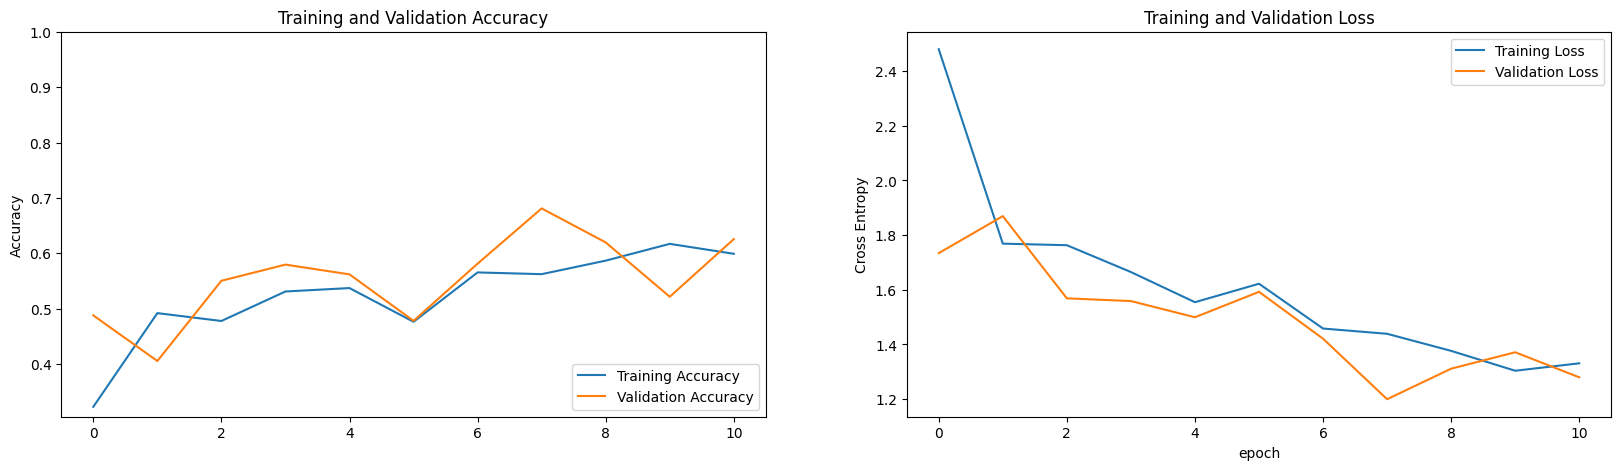

In [24]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(BASE_MODEL_FIG)
plt.show()

fine-tuning

In [25]:

for layer in pretrained_model.layers[:FINE_TUNE_AT]: layer.trainable = False
for layer in pretrained_model.layers[FINE_TUNE_AT:]: layer.trainable = True

In [26]:

from tensorflow.keras.optimizers import SGD
model.compile(
    optimizer = SGD(learning_rate=1e-4, momentum=0.9), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

In [27]:
history_fine = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    epochs = TOTAL_EPOCHS,
    initial_epoch = history.epoch[-1],
    callbacks = [fine_tune_checkpointer, early_stopping],
    verbose = 1,
)
model.save(FINE_TUNE_MODEL_TRAINED)

Epoch 11/30
 21/146 ━━━━━━━━━━━━━━━━━━━━ 1:07:34 32s/step - accuracy: 0.2373 - loss: 3.2085

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.3107 - loss: 2.7213 
Epoch 11: val_loss improved from inf to 1.36741, saving model to Models/InceptionV3/fine_tune_model_best.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 5100s 35s/step - accuracy: 0.3112 - loss: 2.7185 - val_accuracy: 0.6064 - val_loss: 1.3674
Epoch 12/30
  1/146 ━━━━━━━━━━━━━━━━━━━━ 1:20:50 33s/step - accuracy: 0.5391 - loss: 1.5941

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 12: val_loss improved from 1.36741 to 1.29623, saving model to Models/InceptionV3/fine_tune_model_best.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.5391 - loss: 1.5941 - val_accuracy: 0.5652 - val_loss: 1.2962
Epoch 13/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.5231 - loss: 1.6725 
Epoch 13: val_loss did not improve from 1.29623
146/146 ━━━━━━━━━━━━━━━━━━━━ 5038s 34s/step - accuracy: 0.5232 - loss: 1.6720 - val_accuracy: 0.6205 - val_loss: 1.3276
Epoch 13: early stopping


In [28]:

acc += history_fine.history['accuracy']
loss += history_fine.history['loss']
val_acc += history_fine.history['val_accuracy']
val_loss += history_fine.history['val_loss']

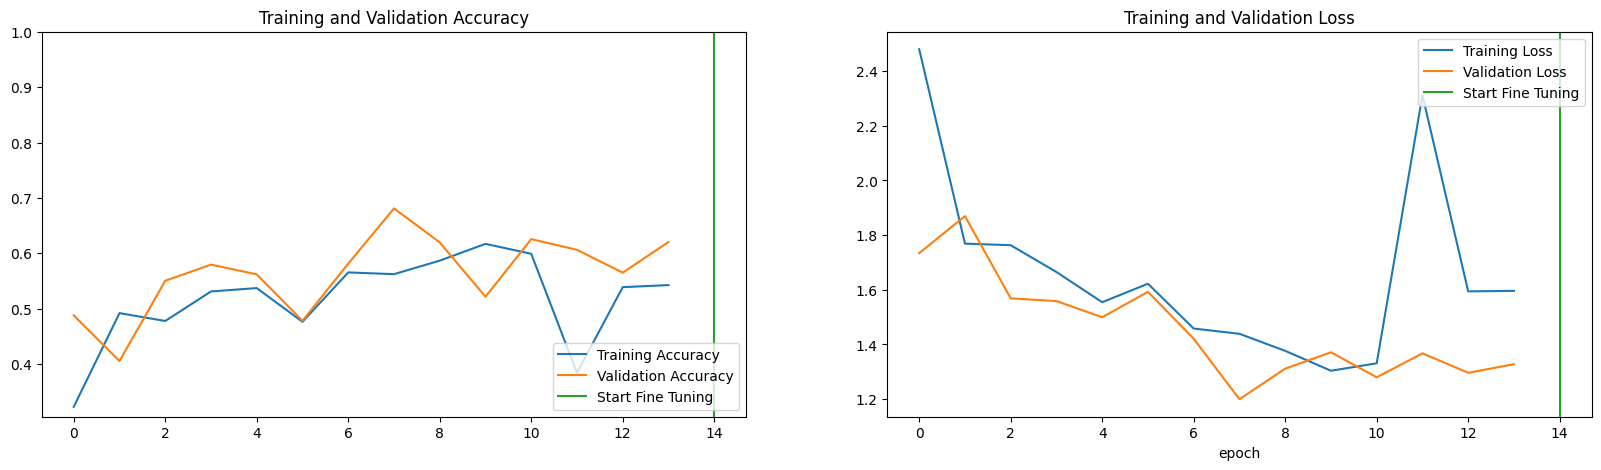

In [29]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([INITIAL_EPOCHS - 1, INITIAL_EPOCHS - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.plot([INITIAL_EPOCHS - 1, INITIAL_EPOCHS - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(FINE_TUNE_MODE_FIG)
plt.show()

In [30]:

loss, accuracy = model.evaluate(generated_test_data)
print('Test accuracy:', accuracy)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 588s 14s/step - accuracy: 0.6348 - loss: 1.2858
Test accuracy: 0.6254594922065735
